In [1]:
import torch, numpy as np, seaborn as sns, matplotlib.pyplot as plt, os, random, warnings
from pathlib import Path
from scipy.stats import pearsonr
from whobpyt.data_loader import BOLDDataLoader, DEVICE
from simulators.rww_simulator import RWWSubjectSimulator
from whobpyt.custom_cost_RWW import CostsRWW
from whobpyt.modelfitting import Model_fitting
sns.set_style("white"); warnings.filterwarnings("ignore")

Using DEVICE = cuda


In [2]:
DATA_ROOT = "/vol/bitbucket/ank121/fyp/HCP Data"
SUBJ      = 18
CHUNK     = 100          # generator forward() window
STACK_K   = 4            # => FC-400 for the disc
G_INIT    = 1200
EPOCHS_G  = 30            # 0 = just load; >0 = quick fine-tune if no file
GEN_PATH  = Path(f"weights/gen_sub{SUBJ:03d}_g{G_INIT}_chunk{CHUNK}.pt")

fmri  = os.path.join(DATA_ROOT, "BOLD Timeseries HCP.mat")
scdir = os.path.join(DATA_ROOT, "distance_matrices")
dist  = os.path.join(DATA_ROOT, "schaefer100_dist.npy")
loader = BOLDDataLoader(fmri, scdir, dist)

[DataLoader] Loaded 100 subjects.


In [3]:
def get_generator():
    sc = loader.get_subject_connectome(SUBJ, norm=True)
    sim = RWWSubjectSimulator( sc, sc.shape[0],
        TP_per_window=CHUNK,
        fit_g_EE=False, fit_g_IE=False, fit_g_EI=True,
        use_fic=True, step_size=0.05, g_init=G_INIT
    )
    sim.model.to(DEVICE)

    if GEN_PATH.exists():
        sim.load_state_dict(torch.load(GEN_PATH, map_location=DEVICE))
        print(f"Generator loaded  ({GEN_PATH.name})")
    else:
        if EPOCHS_G==0:
            raise FileNotFoundError("No trained generator found and EPOCHS_G=0.")
        print("… quick-training generator")
        full_emp = torch.tensor(np.corrcoef(loader.all_bold[SUBJ]), dtype=torch.float32, device=DEVICE)
        cost   = CostsRWW(sim.model)
        fit    = Model_fitting(sim.model, cost, device=DEVICE)
        fit.train(u=0, empFcs=[full_emp],
                  num_epochs=EPOCHS_G,
                  num_windows=loader.all_bold[SUBJ].shape[1]//CHUNK,
                  learningrate=0.1)
        GEN_PATH.parent.mkdir(exist_ok=True, parents=True)
        
        torch.save(sim, GEN_PATH)
        print(f"Generator saved  ({GEN_PATH.name})")
    return sim


In [4]:
sim = get_generator()

… quick-training generator
[Trainer] Fitting 1 FC matrices with 11 windows of 100 TRs
[1 / 1] FC_cor: 0.018
epoch 000  loss=11.5607  g=1199.972  g_EE=3.500  g_EI=1.320 g_IE=0.420 kappa=0.70
[1 / 1] FC_cor: 0.340
epoch 001  loss=9.0354  g=1199.982  g_EE=3.500  g_EI=1.190 g_IE=0.420 kappa=0.61
[1 / 1] FC_cor: 0.390
epoch 002  loss=7.7627  g=1199.976  g_EE=3.500  g_EI=1.020 g_IE=0.420 kappa=0.49
[1 / 1] FC_cor: 0.239
epoch 003  loss=7.3320  g=1199.965  g_EE=3.500  g_EI=1.149 g_IE=0.420 kappa=0.44
[1 / 1] FC_cor: 0.476
epoch 004  loss=6.8179  g=1199.972  g_EE=3.500  g_EI=1.088 g_IE=0.420 kappa=0.12
[1 / 1] FC_cor: 0.246
epoch 005  loss=6.7672  g=1199.971  g_EE=3.500  g_EI=1.083 g_IE=0.420 kappa=0.10
[1 / 1] FC_cor: 0.387
epoch 006  loss=6.4565  g=1199.974  g_EE=3.500  g_EI=1.061 g_IE=0.420 kappa=0.06
[1 / 1] FC_cor: 0.355
epoch 007  loss=6.4109  g=1199.974  g_EE=3.500  g_EI=1.080 g_IE=0.420 kappa=0.15
[1 / 1] FC_cor: 0.374
epoch 008  loss=5.8013  g=1199.977  g_EE=3.500  g_EI=1.055 g_IE=0.4

In [ ]:
GEN_PATH.parent.mkdir(exist_ok=True, parents=True)
torch.save(sim, GEN_PATH)
print(f"Generator saved  ({GEN_PATH})")

print("g  =", sim.model.params.g.val.item())
print("g_EE =", sim.model.params.g_EE.val.item())
print("g_EI =", sim.model.params.g_EI.val.item())

NameError: name 'GEN_PATH' is not defined

In [20]:
ts_emp = loader.all_bold[SUBJ]            # (N,1189)
N,T    = ts_emp.shape
def fc(x): return np.corrcoef(x)

emp_fc_100 = fc(ts_emp[:, :CHUNK])
emp_fc_400 = fc(ts_emp[:, :CHUNK*STACK_K])

In [17]:
with torch.no_grad():
    # simulate 1 forward call per window (no random reset) for STACK_K windows
    ts_sim, _ = sim.simulate(u=0, num_windows=STACK_K, base_window_num=10)
    print(ts_sim.shape)

sim_fc_100  = fc(ts_sim[:, :CHUNK])
sim_fc_400  = fc(ts_sim[:, :CHUNK*STACK_K])


[Simulator] Simulating 4 windows 
(100, 400)


In [14]:
tri = np.tril_indices(N, -1)
def r(a,b): return pearsonr(a[tri], b[tri])[0]

print("\nPearson r (lower-tri):")
print(f"  FC-100  sim vs emp : {r(sim_fc_100, emp_fc_100):+.3f}")
print(f"  FC-400  sim vs emp : {r(sim_fc_400, emp_fc_400):+.3f}")

# variability check – do another run quickly
ts_sim2,_ = sim.simulate(u=0, num_windows=STACK_K, base_window_num=10)
sim_fc_400_b = fc(ts_sim2[:, :CHUNK*STACK_K])
print(f"  FC-400  between two sims : {r(sim_fc_400, sim_fc_400_b):+.3f}")



Pearson r (lower-tri):
  FC-100  sim vs emp : +0.053
  FC-400  sim vs emp : +0.553
[Simulator] Simulating 6 windows 
  FC-400  between two sims : +0.684


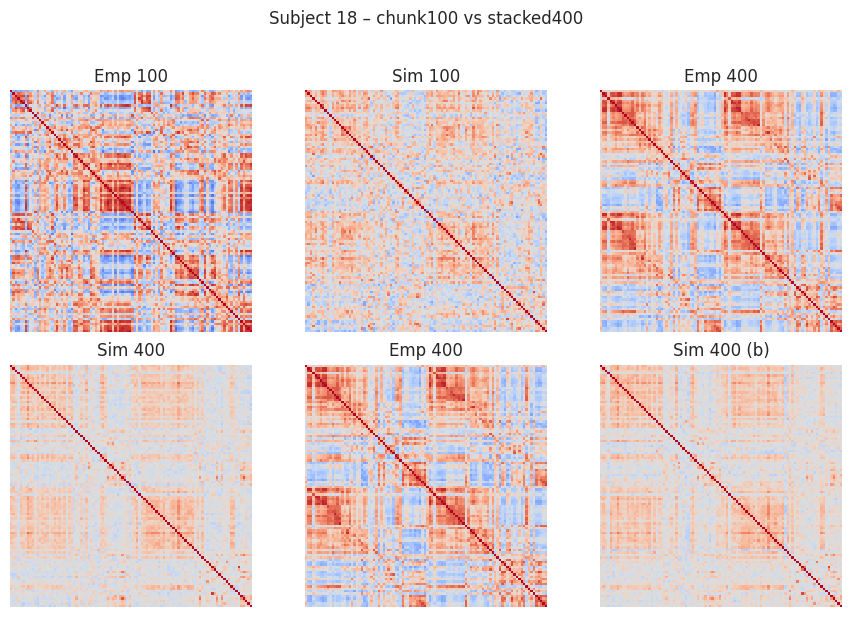

In [15]:
fig,ax = plt.subplots(2,3, figsize=(9,6))
v = dict(vmin=-1,vmax=1,cmap="coolwarm")
for a,m,t in zip(ax.flatten(),
                 [emp_fc_100, sim_fc_100,
                  emp_fc_400, sim_fc_400,
                  emp_fc_400, sim_fc_400_b],
                 ["Emp 100","Sim 100",
                  "Emp 400","Sim 400",
                  "Emp 400","Sim 400 (b)"]):
    sns.heatmap(m, square=True, cbar=False, **v, ax=a)
    a.set_title(t); a.axis('off')
plt.suptitle(f"Subject {SUBJ} – chunk100 vs stacked400", y=1.02)
plt.tight_layout()
plt.show()
